In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm

Preliminaries

First we generate the cosmology, the wavenumber
and scale factor arrays. The arrays are used for computing the power spectrum, $P(k,a)$

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

k_arr = np.geomspace(1E-3, 1e3, 128)  # For evaluating
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.1, 1, 16)

In [3]:
pk_lin = ccl.pk2d.Pk2D( a_arr=a_arr, lk_arr=lk_arr,
                        pk_arr=cosmo.linear_matter_power(np.e**lk_arr, a_arr),
                        is_logp=False)

In [4]:

plt.figure( figsize=(6,4))
a_eval = 1/(1+0.11)
plt.plot(k_arr/cosmo['h'], pk_lin(k_arr, a_eval)*cosmo['h']**3, label='1-h sat.-sat.', c='blue', ls='--')
plt.xscale('log')
plt.yscale('log')


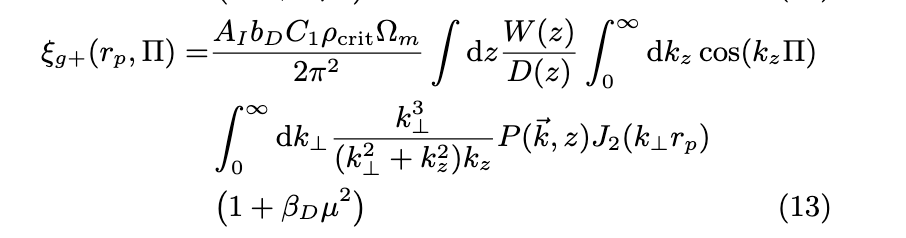

In [5]:
kperp, kz = np.meshgrid(k_arr, k_arr)

In [6]:
from scipy.special import spherical_jn

In [7]:
beta = 1
rp = 5

In [8]:
k_norm = np.sqrt( kperp**2 + kz**2 )
A = pk_lin( k_norm.flatten(), a_eval).reshape( kperp.shape )
B =  kperp**3 / ( ( kperp**2 + kz**2 ) * kz )
C = spherical_jn( 2 , kperp * rp )
D = 1 + beta * kz**2 / k_norm**2
pk_lin_gI = A * B * C * D

In [9]:
plt.imshow( pk_lin_gI )

In [10]:
k_norm = np.sqrt( kperp**2 + kz**2 )
A = pk_lin( k_norm.flatten(), a_eval).reshape( kperp.shape )
B =  kperp**3 / ( ( kperp**2 + kz**2 ) * kz )
C = spherical_jn( 2 , kperp * rp )
D = 1 + beta * kz**2 / k_norm**2
pk_lin_gI = A * B * C * D

In [11]:
from scipy.integrate import dblquad


In [12]:
from scipy.integrate import simps

In [13]:
# Define the integrand
def integrand(kperp, kz, rp , Pi , beta):
    k_norm = np.sqrt(kperp**2 + kz**2)
    A = pk_lin(k_norm, a_eval)
    B = kperp**3 / ((kperp**2 + kz**2) * kz)
    C = spherical_jn(2, kperp * rp)
    D = 1 + beta * kz**2 / k_norm**2
    E = np.cos( kz * Pi )
    return A * B * C * D * E

# Define the integration limits
kperp_min, kperp_max = 1E-3, 1e1
kz_min, kz_max = 1E-3, 1e1

# Perform the integration
rp = 5  # Example value for rp
beta = 0.25  # Example value for beta
Pi = 0
# result, error = dblquad( integrand,
#                          kz_min, 
#                          kz_max, 
#                          lambda kperp: kperp_min, 
#                          lambda kperp: kperp_max, 
#                          args=(rp , 0 , beta) , epsabs=1)

kperp = np.linspace(kperp_min, kperp_max, 100)
kz = np.linspace(kz_min, kz_max, 100)

kperp_grid, kz_grid = np.meshgrid(kperp, kz)

integrand_values = integrand( kperp_grid.flatten(), 
                              kz_grid.flatten(), 
                              rp, Pi, beta).reshape( kperp_grid.shape )
result_kz = simps(integrand_values, kz, axis=0)  # Integrate over kz
result = simps(result_kz, kperp)

print("Integration result:", result)

In [14]:
# Perform the integration
rp = 5  # Example value for rp
beta = 1  # Example value for beta
result, error = dblquad( integrand,
                         kz_min, 
                         kz_max, 
                         lambda kperp: kperp_min, 
                         lambda kperp: kperp_max, 
                         args=(rp , 5 , beta) , epsabs =0.1)

print("Integration result:", result)
print("Integration error:", error)

In [15]:
# Perform the integration
rp = 0  # Example value for rp
beta = 1  # Example value for beta
result, error = dblquad( integrand,
                         kz_min, 
                         kz_max, 
                         lambda kperp: kperp_min, 
                         lambda kperp: kperp_max, 
                         args=(rp , 5 , beta))

print("Integration result:", result)
print("Integration error:", error)

In [16]:
# def xi_gp( rp , Pi , beta = 0.25 , epsabs = 2 ):
#     # result, error = dblquad( integrand,
#     #                      kz_min, 
#     #                      kz_max, 
#     #                      lambda kperp: kperp_min, 
#     #                      lambda kperp: kperp_max, 
#     #                      args=(rp , Pi , beta) , epsabs = epsabs)
    
#     kperp = np.linspace(kperp_min, kperp_max, 100)
#     kz = np.linspace(kz_min, kz_max, 100)

#     kperp_grid, kz_grid = np.meshgrid(kperp, kz)

#     integrand_values = integrand( kperp_grid.flatten(), 
#                                 kz_grid.flatten(), 
#                                 rp, Pi, beta).reshape( kperp_grid.shape )
#     result_kz = simps(integrand_values, kz, axis=0)  # Integrate over kz
#     result = simps(result_kz, kperp)
#     return result

def xi_gp( rp , Pi , beta = 0.25 , epsrel = 0.1 ):
    result, error = dblquad( integrand,
                         kz_min, 
                         kz_max, 
                         lambda kperp: kperp_min, 
                         lambda kperp: kperp_max, 
                         args=(rp , Pi , beta) , epsrel= epsrel )
    return result

In [17]:
xi_gp( 5 , 0 , 1 )

In [18]:
rp = np.linspace( 80 , 200 , 30 )
Pi = np.linspace( 80 , 200 , 30 )


In [19]:
rp_grid, Pi_grid = np.meshgrid( rp , Pi )

In [ ]:
xi_gp_2d = [ xi_gp( rp , Pi ) for rp , Pi in zip( rp_grid.flatten() , Pi_grid.flatten() ) ]

In [ ]:
xi_gp_2d = np.array( xi_gp_2d ).reshape( rp_grid.shape )

In [ ]:
np.save('large_theory_xi_gp_2d.npy', xi_gp_2d)

In [ ]:
# np.save('theory_xi_gp_2d.npy', xi_gp_2d)

In [ ]:
# xi_gp_2d = np.load('theory_xi_gp_2d.npy')

In [ ]:
plt.imshow( xi_gp_2d , origin ='lower')
plt.colorbar()

In [ ]:
plt.imshow( np.log( xi_gp_2d ) , origin ='lower' , vmin = 4.5 , vmax = 5 )
plt.colorbar()

In [ ]:
plt.contourf( np.log( xi_gp_2d ) , 
               origin ='lower' , 
               vmin = 2. , 
               vmax = 5 ,
               extent = [ rp.min() , rp.max() , Pi.min() , Pi.max() ] ,
               #levels = [3,4.2,4.6,4.7,4.9,5,5.1,6] ,
               cmap = cm.Blues )
plt.colorbar()

In [ ]:
r_perp_flat = rp_grid.flatten()
r_par_flat = Pi_grid.flatten()

In [ ]:
r_perp_flat.shape

In [ ]:
xi_gg_p_flat = np.array(xi_gp_2d).flatten()


In [ ]:
xi_gg_p_flat.shape

In [ ]:
# Flatten the xi_gg_p_results and xi_gg_m_results arrays
xi_gg_p_flat = np.array(xi_gp_2d).flatten()
xi_gg_m_flat = np.array(xi_gp_2d).flatten()

# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

# Define bins for s
s_bins = np.linspace(5, 40, 20)
s_cents = (s_bins[1:] + s_bins[:-1]) / 2.

# Initialize arrays to store the results
xi_gg_p_s = np.zeros(len(s_bins) - 1)
var_xi_gg_p_s = np.zeros(len(s_bins) - 1)
counts_p = np.zeros(len(s_bins) - 1)

xi_gg_m_s = np.zeros(len(s_bins) - 1)
var_xi_gg_m_s = np.zeros(len(s_bins) - 1)
counts_m = np.zeros(len(s_bins) - 1)

# Bin the results by s and calculate the radial averages and variances
for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
    if np.any(mask):  # Check if there are any elements in the mask
        xi_gg_p_s[i] = np.mean(xi_gg_p_flat[mask])
        var_xi_gg_p_s[i] = np.var(xi_gg_p_flat[mask])
        counts_p[i] = np.sum(mask)

        xi_gg_m_s[i] = np.mean(xi_gg_m_flat[mask])
        var_xi_gg_m_s[i] = np.var(xi_gg_m_flat[mask])
        counts_m[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_gg_p_s[counts_p == 0] = np.nan
var_xi_gg_p_s[counts_p == 0] = np.nan

xi_gg_m_s[counts_m == 0] = np.nan
var_xi_gg_m_s[counts_m == 0] = np.nan

In [ ]:
h = 0.7

In [ ]:
plt.errorbar( s_cents * h , xi_gg_p_s * s_cents**2, fmt='ko' , yerr = var_xi_gg_p_s**0.5  * s_cents**2 / counts_p**0.5 )
plt.plot(s_cents * h, np.zeros(s_cents.shape), 'k--' )
# plt.errorbar( s_cents , -xi_x_s * s_cents**2, fmt='o' , yerr = var_xi_x_s**0.5  * s_cents**2 / counts_p**0.5 )
#plt.errorbar( s_cents * h , -sticks_xi_p_s * s_cents**2, fmt='o' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
plt.xlabel('s')
plt.ylabel(r'$s^2 \xi_{g+}(s)$')
# plt.xlim( 50 , 200 )
#plt.ylim( -10 , 20 )
#plt.ylim( -0.01 , 0.03 * 100**2 )
plt.show()

In [ ]:
def quadrupole(xi_gn_p, xi_gn_x, s_bins, r_perp_flat, r_par_flat):
    """
    Measure the quadrupole moment of the correlation function.

    Parameters:
    xi_gn_p : ndarray
        The xi_gn_p array (real part of the correlation function).
    xi_gn_x : ndarray
        The xi_gn_x array (imaginary part of the correlation function).
    s_bins : ndarray
        The bins for the separation s.
    r_perp_flat : ndarray
        Flattened array of perpendicular separations.
    r_par_flat : ndarray
        Flattened array of parallel separations.

    Returns:
    xi_p_quad : ndarray
        Quadrupole moment for the real part.
    var_xi_p_quad : ndarray
        Variance of the quadrupole moment for the real part.
    counts_p_quad : ndarray
        Counts for the real part.
    xi_x_quad : ndarray
        Quadrupole moment for the imaginary part.
    var_xi_x_quad : ndarray
        Variance of the quadrupole moment for the imaginary part.
    counts_x_quad : ndarray
        Counts for the imaginary part.
    s_cents : ndarray
        Centers of the separation bins.
    """
    xi_gn_p_flat = xi_gn_p.flatten()
    xi_gn_x_flat = xi_gn_x.flatten()

    # Calculate s and mu for each pair of (r_perp, r_par)
    s = np.sqrt(r_perp_flat**2 + r_par_flat**2)
    mu = r_par_flat / s

    s_cents = (s_bins[1:] + s_bins[:-1]) / 2.

    # Initialize arrays to store the results
    xi_p_quad = np.zeros(len(s_bins) - 1)
    var_xi_p_quad = np.zeros(len(s_bins) - 1)
    counts_p_quad = np.zeros(len(s_bins) - 1)

    xi_x_quad = np.zeros(len(s_bins) - 1)
    var_xi_x_quad = np.zeros(len(s_bins) - 1)
    counts_x_quad = np.zeros(len(s_bins) - 1)

    # Bin the results by s and calculate the quadrupole moments
    for i in range(len(s_bins) - 1):
        mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
        if np.any(mask):  # Check if there are any elements in the mask
            legendre_quad = (3 * mu[mask]**2 - 1) / 2  # Quadrupole Legendre polynomial

            xi_p_quad[i] = np.mean(xi_gn_p_flat[mask] * legendre_quad)
            var_xi_p_quad[i] = np.var(xi_gn_p_flat[mask] * legendre_quad)
            counts_p_quad[i] = np.sum(mask)

            xi_x_quad[i] = np.mean(xi_gn_x_flat[mask] * legendre_quad)
            var_xi_x_quad[i] = np.var(xi_gn_x_flat[mask] * legendre_quad)
            counts_x_quad[i] = np.sum(mask)

    return xi_p_quad, var_xi_p_quad, counts_p_quad, xi_x_quad, var_xi_x_quad, counts_x_quad, s_cents